In [1]:
#Implementation of custom 2D-FFT
import time
import numpy as np
import matplotlib.pyplot as plt
import cv2

#helper-function to read an image
def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

#helper-functions to show an image
def show_img(img, figsize = (5, 5)):
    plt.figure(figsize = figsize)
    plt.imshow(img)
    plt.show()
    
def show_complex_img(img, figsize = (5, 5)):
    plt.figure(figsize = figsize)
    plt.imshow(np.log(abs(img)), interpolation='nearest')
    plt.show()    
    
    

def customFFT(x):
    N = len(x)
    if N == 1:
        #zeroth-bin is just the sample itself; if periodic and well-behaved = 0
        return x
    else:
        #divide the input into even-indexed and odd-indexed sequences

        #store even elements
        x_even = x[::2]

        #store odd elements
        x_odd = x[1::2]

        #start the even fft recursive decimatation until 1 gets returned
        #'drive' resumes on the recursive 'parked' executions on N=2
        X_even = customFFT(x_even)
        X_odd = customFFT(x_odd)

        #taking N-roots from the complex plane
        W_N = np.exp(-2j * np.pi/(N) )

        X_k = np.zeros(N, dtype=np.complex128)

        #multiplying samples with evenly spaced roots on the complex plane; circle-symmetry allows k = N/2
        for k in range(N//2):
            X_k[k] = X_even[k] + W_N ** k * X_odd[k]
            X_k[k + N//2] = X_even[k] - W_N ** k * X_odd[k]

        return X_k

#transform values of greyscale-image
def FFT2D(img):    
    
    xDim,yDim = img.shape
    
    #Container working in function
    temp_arr = np.zeros((xDim,yDim))
    img_arr = np.zeros((xDim,yDim))
    
    #Container to return
    XFrq = np.zeros((xDim,yDim), dtype = np.complex128)
    YFrq = np.zeros((xDim,yDim), dtype = np.complex128)
    
    #Prepare base-array for FFT
    for x in range(xDim):
        for y in range(yDim):
            img_arr[x][y] = img.item(x,y)
            
    #compute FFT for x-direction   
    for xfrq in range(xDim):
        XFrq[xfrq] = customFFT(img_arr[xfrq])

    #get the Y-component     
    temp_arr = XFrq.copy().transpose()
    
    for yfrq in range(yDim):
        YFrq[yfrq] = customFFT(temp_arr[yfrq])
        
    return XFrq, YFrq


def customIFFT2D(Yk):
    
    YFrq = np.asarray(Yk, dtype = np.complex128)
    
    xDim, yDim = YFrq.shape
    
    temp_arr = np.zeros((xDim,yDim), dtype=np.complex128)
    img_arr = np.zeros((xDim,yDim), dtype = np.complex128)
    
    #Use the FFT to rotate back to the sample-data
    for rvrs_y in range(yDim):
        temp_arr[rvrs_y] = customFFT(Yk[rvrs_y])
    
    temp_arr = temp_arr.transpose()
        
    for rvrs_x in range(xDim):
        img_arr[rvrs_x] = customFFT(temp_arr[rvrs_x])
        
    return np.real(np.flip(img_arr))
    

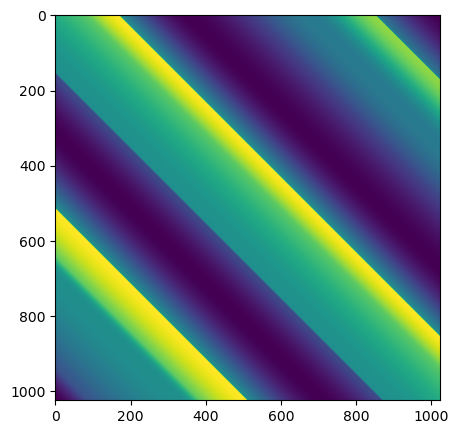

In [2]:
#load sample-data greyscale image 1024 x 1024 

img_path = "./Gradient.png"
img = read_img(img_path)
show_img(img)





In [3]:
#measure the exectution time
st = time.process_time()

#compute the 2D-FFT
Xk, Yk = FFT2D(img)

et = time.process_time()
res = et - st

#lenovo legion 5 15ach
print('CPU Execution time:', res, 'seconds')

CPU Execution time: 11.145620755 seconds


/tmp/ipykernel_103903/3337745581.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(img)), interpolation='nearest')


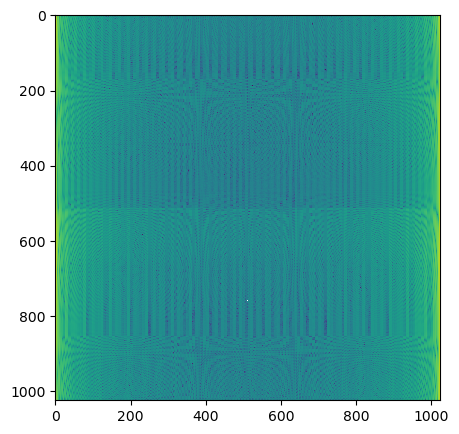

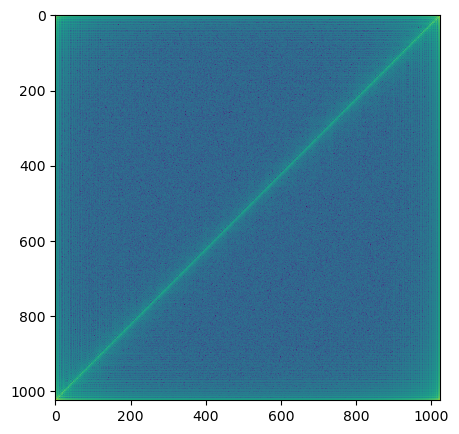

In [4]:
#show frequency Images

show_complex_img(Xk)

show_complex_img(Yk)           

In [5]:
#compute the inverse 2D FFT
restored_img = customIFFT2D(Yk)

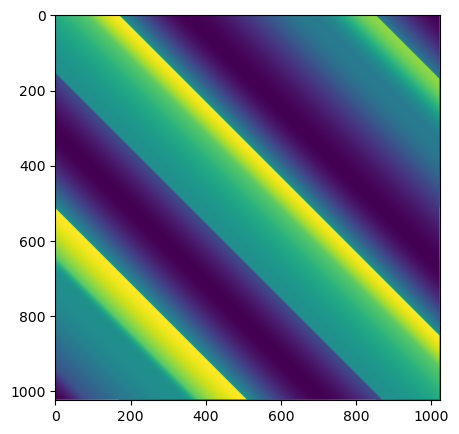

In [6]:
#show restored image data
show_img(restored_img)


In [7]:
#Comparision with np.fft.fft
XF_np = np.fft.fft(img)

#measure the exectution time
st2 = time.process_time()

#use numpy's 2D-FFT
YF_np = np.fft.fft2(img)


et2 = time.process_time()
res2 = et2 - st2


print('CPU Execution time:', res2, 'seconds')
img_np = np.fft.ifft2(YF_np)

CPU Execution time: 0.02512859899999853 seconds


/tmp/ipykernel_103903/3337745581.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(abs(img)), interpolation='nearest')


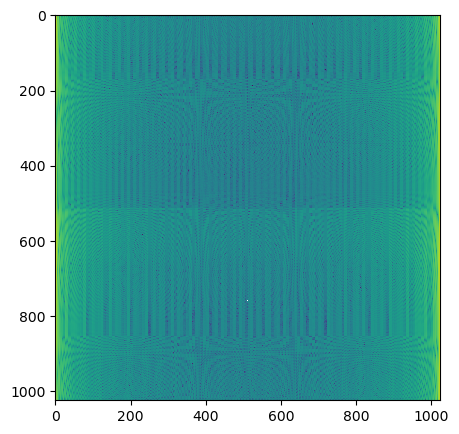

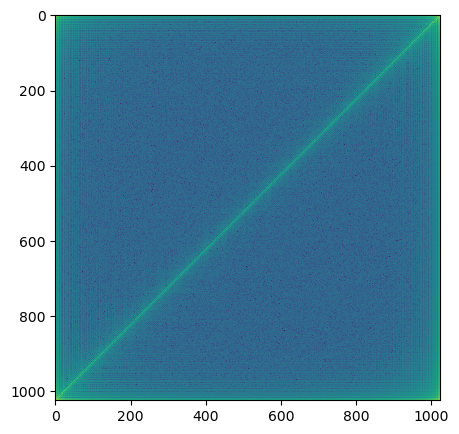

In [8]:
#Show the numpy.fftFrequency-Images
show_complex_img(XF_np)
show_complex_img(YF_np)


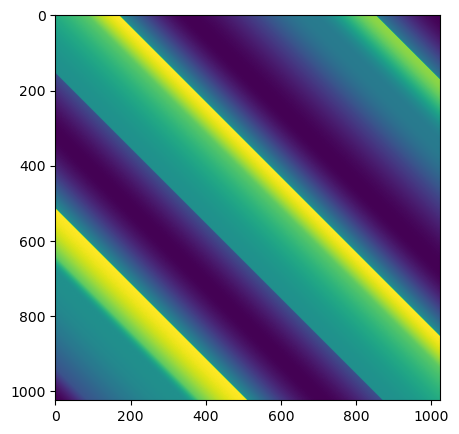

In [9]:
#show restored image
show_img(abs(img_np))